# DQN


### Training of DQN in Tensorflow
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- inform: 1
- closing: 5
- thanks: 7
- greeting: 4
- welcome: 8


### slot set

In [3]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- mpaa_rating: 13
- price: 18
- video_format: 24
- distanceconstraints: 7
- seating: 19


### movie dic: info about movie

In [4]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 453: {'moviename': 'zootopia', 'theater': 'flix brewhouse des moines', 'state': 'iowa', 'starttime': ' around 7pm', 'city': 'des moines', 'mpaa_rating': 'pg', 'date': 'tomorrow'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

hidden_size: 100
learning_rate: 0.001
slot_rep: 1
trained_model_path: None
sdgtype: rmsprop
dia_slot_val: 2
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
eva_metric: 2
max_epochs: 200
act_set: data/dia_acts.txt
batch_size: 16
pretrained_model_path: None
activation_func: relu
feed_recurrence: 0
valid_test: 0
init_rnn: 0
slot_set: data/slot_set.txt
split_method: 1
model: lstm_tanh
write_model_dir: .\checkpoints\template\07102016\
momentum: 0.1
grad_clip: -0.0001
check_point: 20
reg_cost: 0.001
decay_rate: 0.999
smooth_eps: 1e-08
cv_fold: 6
save_check_point: 20


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'diaact': 'request', 'request_slots': {}, 'inform_slots': {'theater': 'carmike summit 16', 'moviename': 'zootopia', 'numberofpeople': '1', 'state': 'al', 'starttime': 'around 2pm', 'city': 'birmingham', 'date': 'today'}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [10]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- theater_chain: ['regal meridian', 'amc', 'amc loews stony brook 17', 'amc hamilton 24', 'amc pacific place 11', 'regency', 'amc loews waterfront 22', 'century', 'amc star john r 15', 'amc star southfield', 'amc lowes oak tree 6', 'amc loews oak tree 6', 'amc showplace carbondale 8', 'century eastport 16', 'amc theater', 'amc ahwatukee 24', ' amc mesa grand 24', 'amc showplace carbondale']


###  Create a User

In [11]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [13]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agent = DQNAgentTF(movie_kb, act_set, slot_set, agent_params)
agt = 10
agent.set_nlg_model(nlg_model)

agent_run_mode:3


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 60
num_episodes = 100

In [16]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [17]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [18]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("Episode: %s" % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: agent.model.update_target_params()
            else: agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [19]:
# def train_agent(agent = agent, num_episode = 1000, num_batches = 100, batch_size = 10, status=status, eval_every = 10, show_every = 100):
#     succ_rates = []
#     epochs = list(range(eval_every, num_episode+1, eval_every))
#     print(epochs)
#     curr_succ_rate = None
#     curr_loss      = None
#     for n_epo in epochs:
#         print("-=-=-=-=-=-= Running: {} - Success = {} | Loss = {} -=-=-=-=-=-=".format(n_epo, curr_succ_rate, curr_loss))
#         # collect experience
#         run_episodes(agent, num_episode=eval_every, status=status, record_training_data = True, is_training = True)
#         # train
#         curr_loss = agent.train(batch_size=batch_size, num_batches=num_batches, show_every = show_every)
#         # eval
#         curr_succ_rate = run_episodes(agent, num_episode=eval_every, status=status, record_training_data = False)
#         display.HTML('<h3>{}</h3> '.format("Success Rate: {}".format(curr_succ_rate)))
#         succ_rates.append(curr_succ_rate)
        
#     return {"x": epochs, 'success_rate': succ_rates}

In [20]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(1000, status)

warm_start starting ...
Warm_Start 60 epochs, success rate 0.25, ave reward 1.8, ave turns 9.6
Current experience replay buffer size 480
warm_start finished, start RL training ...
Episode: 0
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 2601
cur bellman err 8.4346, experience replay pool 2601
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 1 / 1000, Success rate: 0 / 1 Avg reward: -60.00 Avg turns: 42.00
Episode: 1
simulation success rate 0.0, ave reward -56.18, ave turns 34.36
Train on : 4319
cur bellman err 6.9479, experience replay pool 4319
Simulation success rate 0.0, Ave reward -56.18, Ave turns 34.36, Best success rate 0
Progress: 2 / 1000, Success rate: 0 / 2 Avg reward: -60.00 Avg turns: 42.00
Episode: 2
simulation success rate 0.0, ave reward -44.99, ave turns 11.98
Train on : 4918
cur bellman err 8.9918, experience replay pool 4918
Simulation success rate 0.0, Ave reward -44.99, Ave turns 11.98, Best suc

cur bellman err 0.0228, experience replay pool 53981
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 27 / 1000, Success rate: 0 / 27 Avg reward: -59.30 Avg turns: 40.59
Episode: 27
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 56081
cur bellman err 0.0191, experience replay pool 56081
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 28 / 1000, Success rate: 0 / 28 Avg reward: -59.32 Avg turns: 40.64
Episode: 28
simulation success rate 0.0, ave reward -59.88, ave turns 41.76
Train on : 58169
cur bellman err 0.0114, experience replay pool 58169
Simulation success rate 0.0, Ave reward -59.88, Ave turns 41.76, Best success rate 0
Progress: 29 / 1000, Success rate: 0 / 29 Avg reward: -59.34 Avg turns: 40.69
Episode: 29
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 60269
cur bellman err 0.0106, experience replay pool 60269
Simulation success rate 0.0,

cur bellman err 0.0054, experience replay pool 110609
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 54 / 1000, Success rate: 0 / 54 Avg reward: -59.65 Avg turns: 41.30
Episode: 54
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 112709
cur bellman err 0.0032, experience replay pool 112709
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 55 / 1000, Success rate: 0 / 55 Avg reward: -59.65 Avg turns: 41.31
Episode: 55
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 114809
cur bellman err 0.0034, experience replay pool 114809
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 56 / 1000, Success rate: 0 / 56 Avg reward: -59.66 Avg turns: 41.32
Episode: 56
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 116909
cur bellman err 0.0022, experience replay pool 116909
Simulation success rate 0

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 167249
cur bellman err 0.0029, experience replay pool 167249
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 81 / 1000, Success rate: 0 / 81 Avg reward: -59.77 Avg turns: 41.53
Episode: 81
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 169349
cur bellman err 0.0026, experience replay pool 169349
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 82 / 1000, Success rate: 0 / 82 Avg reward: -59.77 Avg turns: 41.54
Episode: 82
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 171449
cur bellman err 0.0039, experience replay pool 171449
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 83 / 1000, Success rate: 0 / 83 Avg reward: -59.77 Avg turns: 41.54
Episode: 83
simulation success rate 0.0, ave reward -59.87, ave turns 41.74
Train on : 1735

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 223703
cur bellman err 0.0025, experience replay pool 223703
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 108 / 1000, Success rate: 0 / 108 Avg reward: -59.82 Avg turns: 41.65
Episode: 108
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 225803
cur bellman err 0.0016, experience replay pool 225803
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 109 / 1000, Success rate: 0 / 109 Avg reward: -59.83 Avg turns: 41.65
Episode: 109
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 227903
cur bellman err 0.0022, experience replay pool 227903
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 110 / 1000, Success rate: 0 / 110 Avg reward: -59.83 Avg turns: 41.65
Episode: 110
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 280403
cur bellman err 0.0025, experience replay pool 280403
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 135 / 1000, Success rate: 0 / 135 Avg reward: -59.86 Avg turns: 41.72
Episode: 135
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 282503
cur bellman err 0.0034, experience replay pool 282503
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 136 / 1000, Success rate: 0 / 136 Avg reward: -59.86 Avg turns: 41.72
Episode: 136
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 284603
cur bellman err 0.0036, experience replay pool 284603
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 137 / 1000, Success rate: 0 / 137 Avg reward: -59.86 Avg turns: 41.72
Episode: 137
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 336580
cur bellman err 0.0018, experience replay pool 336580
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 162 / 1000, Success rate: 0 / 162 Avg reward: -59.85 Avg turns: 41.70
Episode: 162
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 338680
cur bellman err 0.0026, experience replay pool 338680
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 163 / 1000, Success rate: 0 / 163 Avg reward: -59.85 Avg turns: 41.71
Episode: 163
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 340780
cur bellman err 0.0029, experience replay pool 340780
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 164 / 1000, Success rate: 0 / 164 Avg reward: -59.85 Avg turns: 41.71
Episode: 164
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 393280
cur bellman err 0.0018, experience replay pool 393280
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 189 / 1000, Success rate: 0 / 189 Avg reward: -59.87 Avg turns: 41.75
Episode: 189
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 395380
cur bellman err 0.0014, experience replay pool 395380
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 190 / 1000, Success rate: 0 / 190 Avg reward: -59.87 Avg turns: 41.75
Episode: 190
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 397480
cur bellman err 0.0013, experience replay pool 397480
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 191 / 1000, Success rate: 0 / 191 Avg reward: -59.87 Avg turns: 41.75
Episode: 191
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 449900
cur bellman err 0.0021, experience replay pool 449900
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 216 / 1000, Success rate: 0 / 216 Avg reward: -59.89 Avg turns: 41.78
Episode: 216
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 452000
cur bellman err 0.0018, experience replay pool 452000
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 217 / 1000, Success rate: 0 / 217 Avg reward: -59.89 Avg turns: 41.78
Episode: 217
simulation success rate 0.0, ave reward -59.84, ave turns 41.68
Train on : 454084
cur bellman err 0.0026, experience replay pool 454084
Simulation success rate 0.0, Ave reward -59.84, Ave turns 41.68, Best success rate 0
Progress: 218 / 1000, Success rate: 0 / 218 Avg reward: -59.89 Avg turns: 41.78
Episode: 218
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Trai

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 506571
cur bellman err 0.0020, experience replay pool 506571
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 243 / 1000, Success rate: 0 / 243 Avg reward: -59.90 Avg turns: 41.80
Episode: 243
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 508671
cur bellman err 0.0020, experience replay pool 508671
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 244 / 1000, Success rate: 0 / 244 Avg reward: -59.90 Avg turns: 41.80
Episode: 244
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 510771
cur bellman err 0.0016, experience replay pool 510771
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 245 / 1000, Success rate: 0 / 245 Avg reward: -59.90 Avg turns: 41.80
Episode: 245
simulation success rate 0.0, ave reward -59.6, ave turns 41.2
Train on

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 563231
cur bellman err 0.0018, experience replay pool 563231
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 270 / 1000, Success rate: 0 / 270 Avg reward: -59.91 Avg turns: 41.82
Episode: 270
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 565331
cur bellman err 0.0018, experience replay pool 565331
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 271 / 1000, Success rate: 0 / 271 Avg reward: -59.91 Avg turns: 41.82
Episode: 271
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 567431
cur bellman err 0.0022, experience replay pool 567431
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 272 / 1000, Success rate: 0 / 272 Avg reward: -59.91 Avg turns: 41.82
Episode: 272
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on

simulation success rate 0.0, ave reward -59.54, ave turns 41.08
Train on : 619885
cur bellman err 0.0034, experience replay pool 619885
Simulation success rate 0.0, Ave reward -59.54, Ave turns 41.08, Best success rate 0
Progress: 297 / 1000, Success rate: 0 / 297 Avg reward: -59.92 Avg turns: 41.84
Episode: 297
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 621985
cur bellman err 0.0017, experience replay pool 621985
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 298 / 1000, Success rate: 0 / 298 Avg reward: -59.92 Avg turns: 41.84
Episode: 298
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 624085
cur bellman err 0.0019, experience replay pool 624085
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 299 / 1000, Success rate: 0 / 299 Avg reward: -59.92 Avg turns: 41.84
Episode: 299
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Trai

simulation success rate 0.0, ave reward -59.88, ave turns 41.76
Train on : 676469
cur bellman err 0.0124, experience replay pool 676469
Simulation success rate 0.0, Ave reward -59.88, Ave turns 41.76, Best success rate 0
Progress: 324 / 1000, Success rate: 0 / 324 Avg reward: -59.93 Avg turns: 41.85
Episode: 324
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 678569
cur bellman err 0.0095, experience replay pool 678569
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 325 / 1000, Success rate: 0 / 325 Avg reward: -59.93 Avg turns: 41.85
Episode: 325
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 680669
cur bellman err 0.0142, experience replay pool 680669
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 326 / 1000, Success rate: 0 / 326 Avg reward: -59.93 Avg turns: 41.85
Episode: 326
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Trai

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 733151
cur bellman err 0.0041, experience replay pool 733151
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 351 / 1000, Success rate: 0 / 351 Avg reward: -59.93 Avg turns: 41.86
Episode: 351
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 735251
cur bellman err 0.0028, experience replay pool 735251
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 352 / 1000, Success rate: 0 / 352 Avg reward: -59.93 Avg turns: 41.86
Episode: 352
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 737351
cur bellman err 0.0036, experience replay pool 737351
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 353 / 1000, Success rate: 0 / 353 Avg reward: -59.93 Avg turns: 41.86
Episode: 353
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on

simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 789841
cur bellman err 0.0015, experience replay pool 789841
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 378 / 1000, Success rate: 0 / 378 Avg reward: -59.94 Avg turns: 41.87
Episode: 378
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 791941
cur bellman err 0.0015, experience replay pool 791941
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 379 / 1000, Success rate: 0 / 379 Avg reward: -59.94 Avg turns: 41.87
Episode: 379
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 794041
cur bellman err 0.0014, experience replay pool 794041
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 380 / 1000, Success rate: 0 / 380 Avg reward: -59.94 Avg turns: 41.87
Episode: 380
Successful Dialog!
simulation success rate 0.12, ave reward -44.2, ave

KeyboardInterrupt: 

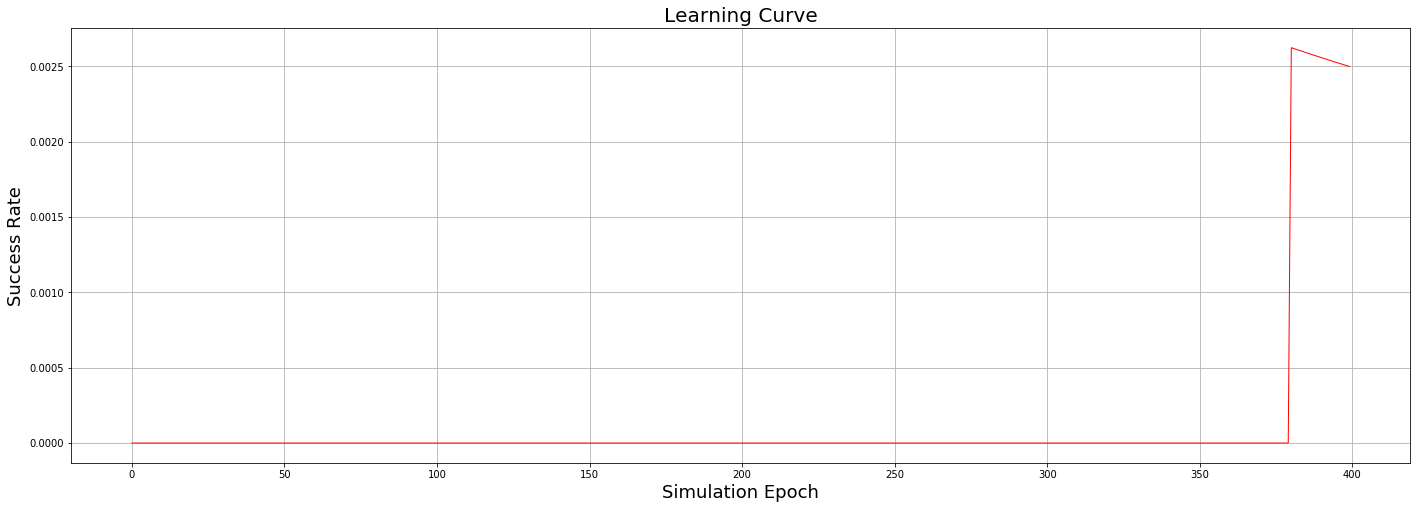

In [21]:
draw_learning_curve(curve)

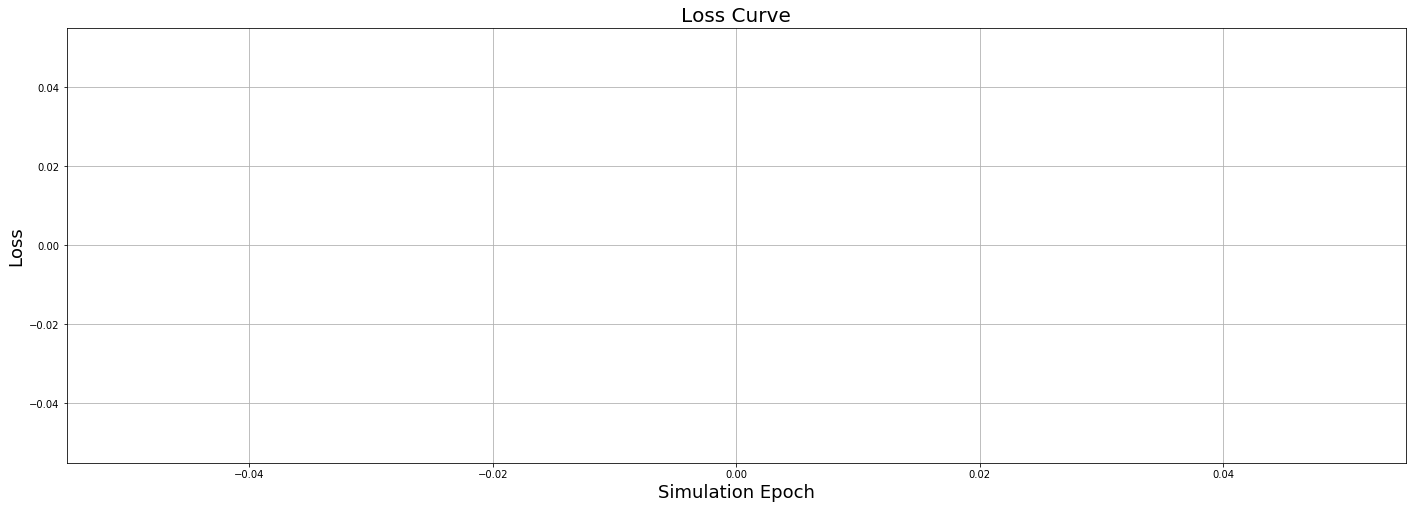

In [22]:
draw_loss_curve(losses)